# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#File Paths

In [ ]:
save_path = "/content/drive/MyDrive//CNXSIA001_LAIDS_SOURCE_CODE/Baseline 1D CNN Model Files/Models" # Model path
dataset_path =  "/content/drive/MyDrive/CNXSIA001_LAIDS_SOURCE_CODE/Baseline 1D CNN Model Files/Datasets"

#Imports

In [ ]:
import os
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Dense, Input, Dropout, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


#Load Datasets

In [ ]:
#Encoding map
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Create a mapping from attack type to integer label

# Training sets
X_train = pd.read_csv(os.path.join(dataset_path, "adasyn_baseline_X_train.csv")).to_numpy()
y_train = pd.read_csv(os.path.join(dataset_path, "adasyn_baseline_y_train.csv")).to_numpy().ravel()

# Validation sets
X_val = pd.read_csv(os.path.join(dataset_path, "baseline_X_val.csv")).to_numpy()
y_val = pd.read_csv(os.path.join(dataset_path, "baseline_y_val.csv")).to_numpy().ravel()

# Test sets
X_test = pd.read_csv(os.path.join(dataset_path, "baseline_X_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(dataset_path, "baseline_y_test.csv")).to_numpy().ravel()

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Check dataset shapes
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:",   X_val.shape,   "y_val:",   y_val.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)


# Print distributions
def print_class_distribution(label, name=""):
    classes, counts = np.unique(label, return_counts=True)
    print(f"\n{name} set class distribution:")
    for c, num in zip(classes, counts):
        print(f"  Class {c}: {num}")

    print(f"  Total: {len(label)}")

print_class_distribution(y_train, "Training")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")



X_train: (2111605, 52, 1) y_train: (2111605,)
X_val: (143534, 52, 1) y_val: (143534,)
X_test: (294645, 52, 1) y_test: (294645,)

Training set class distribution:
  Class 0: 301688
  Class 1: 301212
  Class 2: 301702
  Class 3: 301697
  Class 4: 301715
  Class 5: 301702
  Class 6: 301889
  Total: 2111605

Validation set class distribution:
  Class 0: 75423
  Class 1: 14511
  Class 2: 343
  Class 3: 1464
  Class 4: 20482
  Class 5: 312
  Class 6: 30999
  Total: 143534

Test set class distribution:
  Class 0: 209506
  Class 1: 18139
  Class 2: 429
  Class 3: 1830
  Class 4: 25603
  Class 5: 389
  Class 6: 38749
  Total: 294645


#Remove Class Function

In [ ]:
def Remove_attack_type(attack_type):
    global X_train, y_train
    global X_val, y_val

    # Filter training set
    mask_train = (y_train != attack_type) # Create a new array, mask_train (same shape as y_train), where values are added if the corresponding value in y_train is not equal to attack_type
    X_train_filtered = X_train[mask_train]
    y_train_filtered = y_train[mask_train]

    # Filter validation set
    mask_val = (y_val != attack_type)
    X_val_filtered = X_val[mask_val]
    y_val_filtered = y_val[mask_val]

    # Print filtered class distributions
    def print_class_distribution(y, name=""):
        classes, counts = np.unique(y, return_counts=True)
        print(f"\n{name} set class distribution:")
        for c, num in zip(classes, counts):
            print(f"  Class {c}: {num}")

        print(f"  Total: {len(y)}")

    print_class_distribution(y_train_filtered, "Filtered Training")
    print_class_distribution(y_val_filtered, "Filtered Validation")

    return X_train_filtered, y_train_filtered, X_val_filtered, y_val_filtered


# Build Model Function

In [ ]:
def build_cnn():
      global X_train, y_train

      # Define input shape
      input_shape = (X_train.shape[1],1)  # Shape into: (number of features, 1)
      num_classes = len(np.unique(y_train))

      # Build model
      model = Sequential([
      Input(shape=input_shape),

      Conv1D(filters=32, kernel_size=2, activation='relu'), # Detect patterns in the network traffic data
      BatchNormalization(),                                 # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
      MaxPooling1D(pool_size=2),                            # Reduce the dimensions of the data without removing key features

      Conv1D(filters=16, kernel_size=3, activation='relu'),
      BatchNormalization(),
      MaxPooling1D(pool_size=2),

      GlobalAveragePooling1D(),
      Dense(64, activation='relu'),
      Dropout(0.3),                                        # Randomly drop 30% of the network's neurons to further prevent overfitting
      Dense(num_classes, activation='softmax')             # Final output layer for multiclass classification
      ])

      # Compile
      model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

      # Summary
      model.summary()

      return model

# Train model Function

In [ ]:
def train_cnn(model, new_X_train, new_y_train, new_X_val, new_y_val): # Train the model

  # --- Early-stopping ---
  early_stopping = EarlyStopping(monitor='val_loss',        # Specify monitor='val_loss' to track the validation loss.
                                patience=4,                 #the number of epochs to wait for an improvement
                                restore_best_weights=True)  # Revert the model to its state where it outputted the lowest validation loss


  # Train the model
  history = model.fit(
      new_X_train, new_y_train,
      epochs=20,
      batch_size=64,
      validation_data=(new_X_val, new_y_val),
      callbacks=[early_stopping],
      verbose=1
  )


  # Plot Accuracy and Loss
  plt.figure(figsize=(12,5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Acc')
  plt.plot(history.history['val_accuracy'], label='Val Acc')
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


  return model # Return the trained model

# Test the model on the test dataset

In [ ]:
def test_models(model):
    global X_test,y_test

    # Get models predictions of x_test dataset
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

    # Create confusion matrix plot
    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"FP32 Baseline CNN - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Print accuracy & classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

    # Calculate malware vs benign sample metrics
    normal_traffic = attack_type_map.get('Normal Traffic', None)
    if normal_traffic is not None:
        total_benign = np.sum(cm[normal_traffic, :])
        benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
        benign_misclassified =  total_benign - benign_identified_correctly #FP

        tn = benign_identified_correctly
        fp = benign_misclassified

        total_malware = len(X_test) - total_benign
        print(f"Total Mal: {len(X_test) - total_benign} & {np.sum(cm) - np.sum(cm[normal_traffic, :])}")

        malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]

        total_malware_identified = 0
        for i in range(len(labels)):
            if i != normal_traffic:  # skip the normal traffic row in the cm
                malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                total_malware_identified += malware_predicted_as_any_malware

        malware_misclassified = total_malware - total_malware_identified

        fn = malware_misclassified
        tp = total_malware_identified

        print(f"Total Malware Samples: {total_malware}")
        print(f"Total Benign Samples: {total_benign}")

        # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
        print("\nTP, TN, FP, FN for Malware vs Benign:")
        print(f"True Positives (Malware predicted as ANY malware): {tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
        print(f"True Negatives (Benign predicted as Benign): {tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
        print(f"False Positives (Benign predicted as Malware): {fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
        print(f"False Negatives (Malware predicted as Benign): {fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

        print("\nPercentage of each Malware Class Correctly Identified:")
        for i, label in enumerate(labels):
            if i != normal_traffic: # Exclude 'Normal Traffic' rows
                correctly_identified = cm[i, i]
                total_in_class = np.sum(cm[i, :])
                percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                print(f"{label}: {percentage_identified:.2f}%")

        # ---- Performance Metrics ---
        #Accuracy
        accuracy = (tp + tn)/(tp + tn + fp + fn)
        # Precision (for malware class)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        # Recall / Sensitivity (for malware class)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        # F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        # False Positive Rate (FPR)
        fpr = (fp / (fp + tn))*100 if (fp + tn) > 0 else 0
        # False Negative Rate (FNR)
        fnr = (fn / (fn + tp))*100 if (fn + tp) > 0 else 0

        print("\n--- Malware vs Benign Performance Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Malware): {precision:.4f}")
        print(f"Recall / Sensitivity (Malware): {recall:.4f}")
        print(f"F1-Score (Malware): {f1_score:.4f}")
        print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
        print(f"False Negative Rate (Malware missed): {fnr:.2f}%")




#Quant Models

In [ ]:
def make_representative_dataset_gen(new_X_train, new_y_train):
    if len(new_X_train) == 0:
        raise ValueError("Representative dataset error!")
    def representative_dataset_gen():
        class_types = np.unique(new_y_train)
        class_indices = [np.where(new_y_train == c)[0] for c in class_types]

        rng = np.random.default_rng(seed=1)
        selected_indices = []
        for indices in class_indices:
            selected_indices.extend(rng.choice(indices, 50, replace=False))

        rng.shuffle(selected_indices)

        for i in selected_indices:
            yield [np.expand_dims(new_X_train[i].astype(np.float32), 0)]

    return representative_dataset_gen #Return the representative_dataset_gen function


def quant_models(cnn_model, new_y_train, new_X_train):
    # --- Float32 baseline (no quantization) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
    quantModel_f32 = converter.convert() # Convert the model

    # --- Weight-only quantization (int8 weights, float32 activations) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantModel_int8_weights = converter.convert()

    # --- Weight-only quantization (float16 weights, float32 activations) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    quantModel_fp16_weights = converter.convert()

    # --- Full Integer Model Quantization ---
    converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = make_representative_dataset_gen(new_X_train, new_y_train)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # Set the input and output types to int8 for inference
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    quantModel_full_int8 = converter.convert()

    print("Quant Models Ready!")

    return (
        quantModel_f32, quantModel_int8_weights, quantModel_fp16_weights, quantModel_full_int8
    )


#Evaluate Quant Models

Evaluate the FP32, FP16 and Dynamic INT8

In [ ]:
def evaluate_weight_quant_model(tflite_weight_models):
  global X_test, y_test

  for m in tflite_weight_models:

        the_model = m["model"]
        model_name = m["name"]
        print(f"\n --- Evaluating: {model_name} ---")

        # Load the TFLite model and get it ready to make predictions
        interpreter = tf.lite.Interpreter(model_content=the_model) # Create interpreter object that will read and run the TFLite model
        interpreter.allocate_tensors() # Make the interpreter allocate memory
        input_details = interpreter.get_input_details() # Get expected shape and data type of the data the model needs to evaluate
        output_details = interpreter.get_output_details() # Shape and data type the model will need to produce the results in

        # Get model predictions for test sample
        y_pred_probs = []

        for i in range(len(X_test)): # Interpreter object does not have a built-in .evaluate() method like the Keras Model object does, therefore need to go through every sample manually
            input_data = np.expand_dims(X_test[i], axis=0).astype(input_details[0]['dtype']) # shape the input sample
            interpreter.set_tensor(input_details[0]['index'], input_data) #Feed a single sample of input data into the TFLite interpreter
            interpreter.invoke() # Tell the interpreter to run the model on the input data
            output_data = interpreter.get_tensor(output_details[0]['index']) # Get the output from the model
            y_pred_probs.append(output_data[0]) # Add the raw output to the list

        y_pred_probs = np.array(y_pred_probs) # Convert the list to a single NumPy array
        y_pred = np.argmax(y_pred_probs, axis=1) # Get the predicted class label for each sample


        # --- Confusion Matrix ---
        cm = confusion_matrix(y_test, y_pred)
        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

        # Create confusion matrix plot
        plt.figure(figsize=(8, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title(f"{model_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # Print accuracy & classification report
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=labels))

        # Calculate malware vs benign sample metrics
        normal_traffic = attack_type_map.get('Normal Traffic', None)
        if normal_traffic is not None:
            total_benign = np.sum(cm[normal_traffic, :])
            benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
            benign_misclassified =  total_benign - benign_identified_correctly #FP

            tn = benign_identified_correctly
            fp = benign_misclassified

            total_malware = len(X_test) - total_benign
            print(f"Total Mal: {len(X_test) - total_benign} & {np.sum(cm) - np.sum(cm[normal_traffic, :])}")

            malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]

            total_malware_identified = 0
            for i in range(len(labels)):
                if i != normal_traffic:  # Skip the normal traffic row in the cm
                    malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                    total_malware_identified += malware_predicted_as_any_malware

            malware_misclassified = total_malware - total_malware_identified

            fn = malware_misclassified
            tp = total_malware_identified

            print(f"Total Malware Samples: {total_malware}")
            print(f"Total Benign Samples: {total_benign}")

            # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
            print(f"True Positives (Malware predicted as ANY malware): {tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
            print(f"True Negatives (Benign predicted as Benign): {tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
            print(f"False Positives (Benign predicted as Malware): {fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
            print(f"False Negatives (Malware predicted as Benign): {fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

            print("\nPercentage of each Malware Class Correctly Identified:")
            for i, label in enumerate(labels):
                if i != normal_traffic: # Exclude 'Normal Traffic'
                    correctly_identified = cm[i, i]
                    total_in_class = np.sum(cm[i, :])
                    percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                    print(f"{label}: {percentage_identified:.2f}%")

            # ---- Performance Metrics ---
            #Accuracy
            accuracy = (tp + tn)/(tp + tn + fp + fn)
            # Precision (for malware class)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            # Recall / Sensitivity (for malware class)
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            # F1-Score
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            # False Positive Rate (FPR)
            fpr = (fp / (fp + tn))*100 if (fp + tn) > 0 else 0
            # False Negative Rate (FNR)
            fnr = (fn / (fn + tp))*100 if (fn + tp) > 0 else 0

            print("\n--- Malware vs Benign Performance Metrics ---")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Malware): {precision:.4f}")
            print(f"Recall / Sensitivity (Malware): {recall:.4f}")
            print(f"F1-Score (Malware): {f1_score:.4f}")
            print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
            print(f"False Negative Rate (Malware missed): {fnr:.2f}%")





Evaluate the Full INT8

In [ ]:
def evaluate_full_int8_quant_model(tflite_full_int_models):
    global X_test, y_test

    for m in tflite_full_int_models:
        the_model = m["model"]
        model_name = m["name"]
        print(f"\n--- Evaluating: {model_name} ---")

        interpreter = tf.lite.Interpreter(model_content=the_model)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]

        # Get quanitsation scaling and zero point values
        in_scale,  in_zp  = input_details['quantization']
        out_scale, out_zp = output_details['quantization']

        # Predictions
        y_pred_probs = []
        for i in range(len(X_test)):
            sample_input = np.expand_dims(X_test[i], axis=0).astype(input_details['dtype']) # Shape the sample data and change its data type

            if input_details['dtype'] == np.int8: # Quantise input for int8 model
                quant_sample_input = np.round(sample_input / in_scale + in_zp).astype(np.int8)

            interpreter.set_tensor(input_details['index'], quant_sample_input)
            interpreter.invoke()
            quant_sample_output = interpreter.get_tensor(output_details['index'])

            if output_details['dtype'] == np.int8:# Dequantise output back to float
                sample_output = (quant_sample_output.astype(np.float32) - out_zp) * out_scale

            y_pred_probs.append(sample_output[0])

        y_pred_probs = np.array(y_pred_probs)
        y_pred = np.argmax(y_pred_probs, axis=1)


        # --- Confusion Matrix ---
        cm = confusion_matrix(y_test, y_pred)
        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])]

        # Plot heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title(f"{model_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # Accuracy & classification report
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=labels))

        # Calculate malware vs benign sample metrics
        normal_traffic = attack_type_map.get('Normal Traffic', None)
        if normal_traffic is not None:
            total_benign = np.sum(cm[normal_traffic, :])
            benign_identified_correctly = cm[normal_traffic, normal_traffic] #TN
            benign_misclassified =  total_benign - benign_identified_correctly #FP

            tn = benign_identified_correctly
            fp = benign_misclassified

            total_malware = len(X_test) - total_benign

            malware_identified_correctly = np.sum(np.diag(cm)) - cm[normal_traffic, normal_traffic]

            total_malware_identified = 0
            for i in range(len(labels)):
                if i != normal_traffic:  # skip the normal traffic row in the cm
                    malware_predicted_as_any_malware = np.sum(cm[i, :]) - cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                    total_malware_identified += malware_predicted_as_any_malware

            malware_misclassified = total_malware - total_malware_identified

            fn = malware_misclassified
            tp = total_malware_identified

            print(f"Total Malware Samples: {total_malware}")
            print(f"Total Benign Samples: {total_benign}")

            # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
            print("\nTP, TN, FP, FN for Malware vs Benign:")

            print(f"True Positives (Malware predicted as ANY malware): {tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
            print(f"True Negatives (Benign predicted as Benign): {tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
            print(f"False Positives (Benign predicted as Malware): {fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
            print(f"False Negatives (Malware predicted as Benign): {fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

            print("\nPercentage of each Malware Class Correctly Identified:")
            for i, label in enumerate(labels):
                if i != normal_traffic: # Exclude 'Normal Traffic'
                    correctly_identified = cm[i, i]
                    total_in_class = np.sum(cm[i, :])
                    percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                    print(f"{label}: {percentage_identified:.2f}%")

            # ---- Performance Metrics ---
            #Accuracy
            accuracy = (tp + tn)/(tp + tn + fp + fn)
            # Precision (for malware class)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            # Recall / Sensitivity (for malware class)
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            # F1-Score
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            # False Positive Rate (FPR)
            fpr = (fp / (fp + tn))*100 if (fp + tn) > 0 else 0
            # False Negative Rate (FNR)
            fnr = (fn / (fn + tp))*100 if (fn + tp) > 0 else 0

            print("\n--- Malware vs Benign Performance Metrics ---")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Malware): {precision:.4f}")
            print(f"Recall / Sensitivity (Malware): {recall:.4f}")
            print(f"F1-Score (Malware): {f1_score:.4f}")
            print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
            print(f"False Negative Rate (Malware missed): {fnr:.2f}%")


#REMOVING DoS


Filtered Training set class distribution:
  Class 0: 301688
  Class 1: 301212
  Class 2: 301702
  Class 3: 301697
  Class 4: 301715
  Class 5: 301702
  Total: 1809716

Filtered Validation set class distribution:
  Class 0: 75423
  Class 1: 14511
  Class 2: 343
  Class 3: 1464
  Class 4: 20482
  Class 5: 312
  Total: 112535


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 51, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 51, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 23, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,383 (13.21 KB)

 Trainable params: 3,287 (12.84 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - accuracy: 0.8706 - loss: 0.3743 - val_accuracy: 0.6948 - val_loss: 1.1411
Epoch 2/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - accuracy: 0.9452 - loss: 0.1454 - val_accuracy: 0.9278 - val_loss: 0.2526
Epoch 3/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - accuracy: 0.9528 - loss: 0.1298 - val_accuracy: 0.9598 - val_loss: 0.1440
Epoch 4/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.9581 - loss: 0.1183 - val_accuracy: 0.9465 - val_loss: 0.1764
Epoch 5/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step - accuracy: 0.9636 - loss: 0.1085 - val_accuracy: 0.9533 - val_loss: 0.1572
Epoch 6/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - accuracy: 0.9664 - loss: 0.1027 - val_accuracy: 0.9611 - val_loss: 0.1210
Epoch 7/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 0.9709 - loss: 0.0935 - val_accuracy: 0.9574 - val_loss: 0.1390
Epoch 8/20
28277/28277 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accura

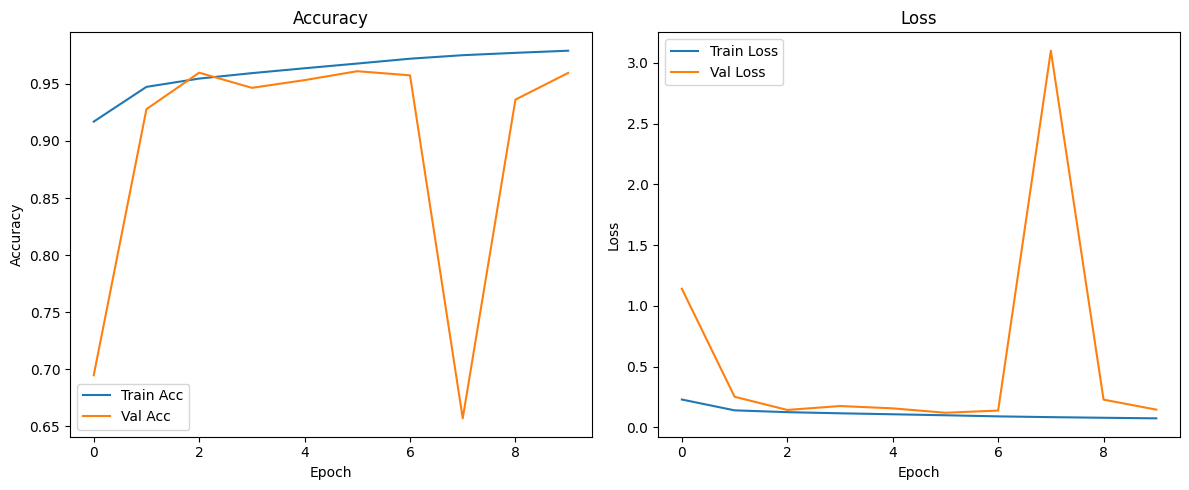

9208/9208 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


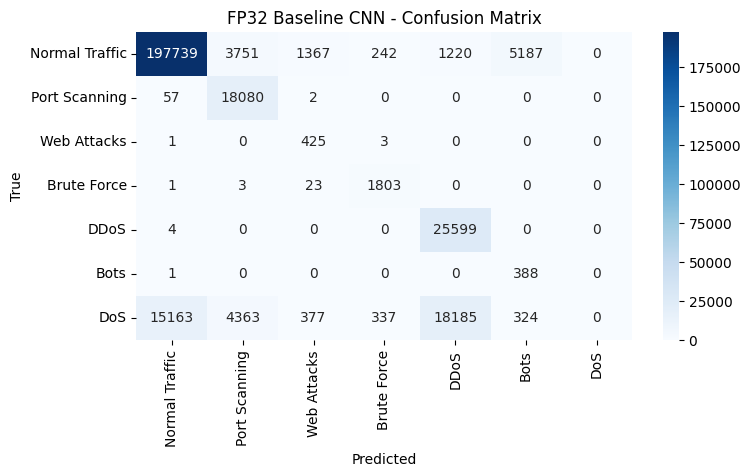

Accuracy: 0.8282305825654601
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.93      0.94      0.94    209506
 Port Scanning       0.69      1.00      0.82     18139
   Web Attacks       0.19      0.99      0.32       429
   Brute Force       0.76      0.99      0.86      1830
          DDoS       0.57      1.00      0.73     25603
          Bots       0.07      1.00      0.12       389
           DoS       0.00      0.00      0.00     38749

      accuracy                           0.83    294645
     macro avg       0.46      0.84      0.54    294645
  weighted avg       0.76      0.83      0.78    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 69912 (82.12% of Malware Identified)
True Negatives (Benign predicted as Benign): 197739 (94.38% of Benign Identified)
False Positives (Benign predicted as 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Removing DoS
dos_encoding = 6

# # --- Get filtered datasets ---
X_train_no_DoS, y_train_no_DoS, X_val_no_DoS, y_val_no_DoS = Remove_attack_type(dos_encoding)

# --- Get the cnn Model ---
cnn = build_cnn()

# --- Train the cnn on the new datasets ---
cnn = train_cnn(cnn, X_train_no_DoS, y_train_no_DoS, X_val_no_DoS, y_val_no_DoS)

# --- Test the models ---
test_models(cnn)


Saved artifact at '/tmp/tmpjyqm6ihv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136242619316752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242619318096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617125008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617125200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617124048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617124432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617125968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617125776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617126928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617127120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136242617125584: Ten

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quant Models Ready!

 --- Evaluating: CNN Float32 Model ---


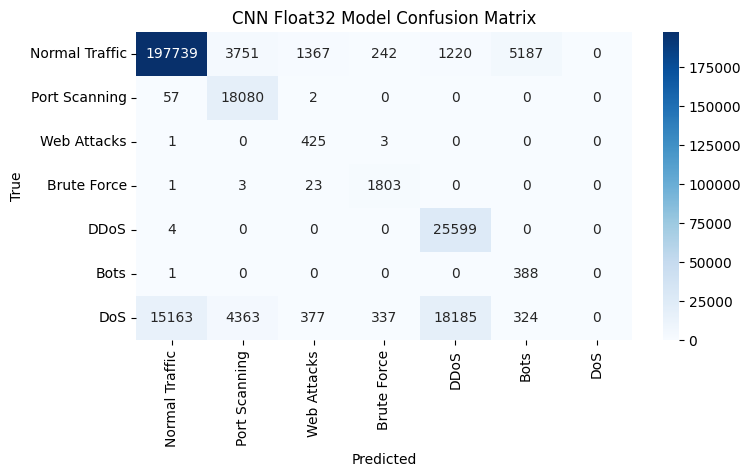

Accuracy: 0.8282305825654601
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.93      0.94      0.94    209506
 Port Scanning       0.69      1.00      0.82     18139
   Web Attacks       0.19      0.99      0.32       429
   Brute Force       0.76      0.99      0.86      1830
          DDoS       0.57      1.00      0.73     25603
          Bots       0.07      1.00      0.12       389
           DoS       0.00      0.00      0.00     38749

      accuracy                           0.83    294645
     macro avg       0.46      0.84      0.54    294645
  weighted avg       0.76      0.83      0.78    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506
True Positives (Malware predicted as ANY malware): 69912 (82.12% of Malware Identified)
True Negatives (Benign predicted as Benign): 197739 (94.38% of Benign Identified)
False Positives (Benign predicted as Malware): 11767 (5.62% of Benign Miscla

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/tensorflo

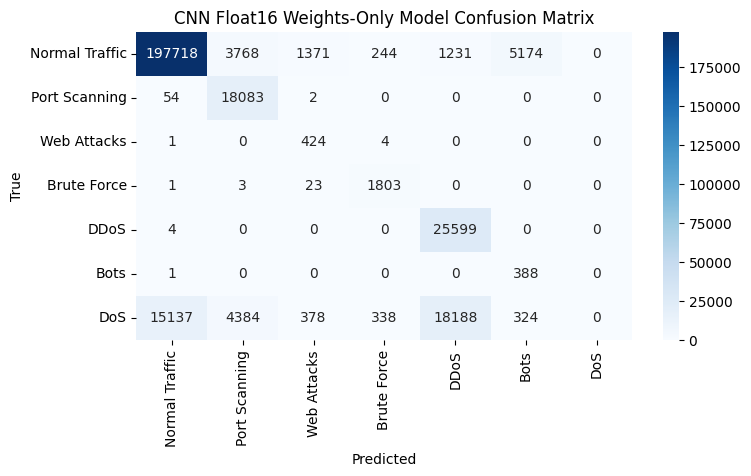

Accuracy: 0.8281660981859525
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.93      0.94      0.94    209506
 Port Scanning       0.69      1.00      0.81     18139
   Web Attacks       0.19      0.99      0.32       429
   Brute Force       0.75      0.99      0.85      1830
          DDoS       0.57      1.00      0.72     25603
          Bots       0.07      1.00      0.12       389
           DoS       0.00      0.00      0.00     38749

      accuracy                           0.83    294645
     macro avg       0.46      0.84      0.54    294645
  weighted avg       0.76      0.83      0.78    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506
True Positives (Malware predicted as ANY malware): 69941 (82.15% of Malware Identified)
True Negatives (Benign predicted as Benign): 197718 (94.37% of Benign Identified)
False Positives (Benign predicted as Malware): 11788 (5.63% of Benign Miscla

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/tensorflo

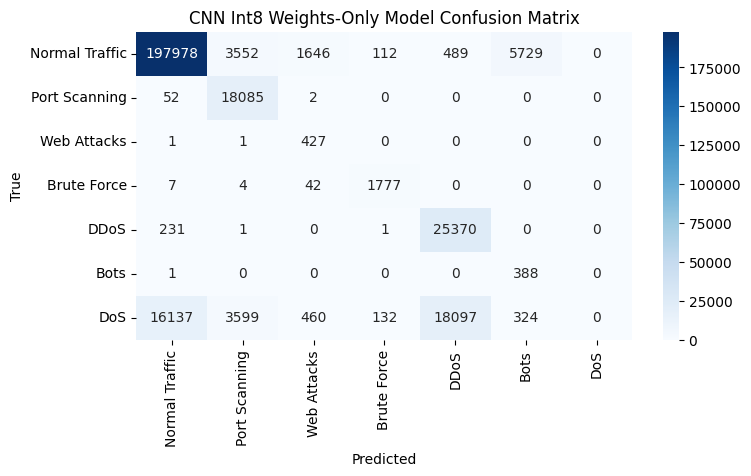

Accuracy: 0.8282000373330618
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.92      0.94      0.93    209506
 Port Scanning       0.72      1.00      0.83     18139
   Web Attacks       0.17      1.00      0.28       429
   Brute Force       0.88      0.97      0.92      1830
          DDoS       0.58      0.99      0.73     25603
          Bots       0.06      1.00      0.11       389
           DoS       0.00      0.00      0.00     38749

      accuracy                           0.83    294645
     macro avg       0.47      0.84      0.55    294645
  weighted avg       0.76      0.83      0.79    294645

Total Mal: 85139 & 85139
Total Malware Samples: 85139
Total Benign Samples: 209506
True Positives (Malware predicted as ANY malware): 68710 (80.70% of Malware Identified)
True Negatives (Benign predicted as Benign): 197978 (94.50% of Benign Identified)
False Positives (Benign predicted as Malware): 11528 (5.50% of Benign Miscla

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/tensorflo

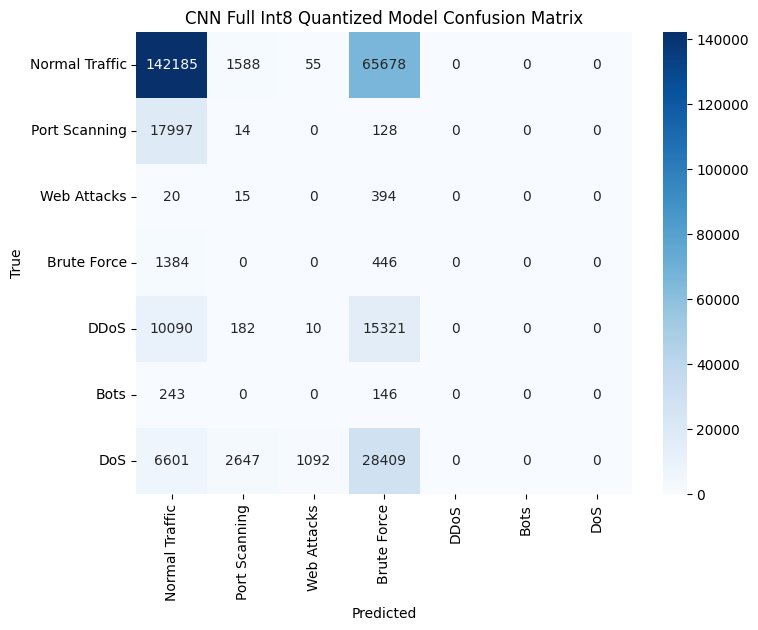

Accuracy: 0.4841249639396562
Classification Report:
                precision    recall  f1-score   support

Normal Traffic       0.80      0.68      0.73    209506
 Port Scanning       0.00      0.00      0.00     18139
   Web Attacks       0.00      0.00      0.00       429
   Brute Force       0.00      0.24      0.01      1830
          DDoS       0.00      0.00      0.00     25603
          Bots       0.00      0.00      0.00       389
           DoS       0.00      0.00      0.00     38749

      accuracy                           0.48    294645
     macro avg       0.11      0.13      0.11    294645
  weighted avg       0.57      0.48      0.52    294645

Total Malware Samples: 85139
Total Benign Samples: 209506

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 48804 (57.32% of Malware Identified)
True Negatives (Benign predicted as Benign): 142185 (67.87% of Benign Identified)
False Positives (Benign predicted as Malware): 67321 (32.13% o

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -----------------------------------
# --- Make Quant Models -------------
# -----------------------------------
quantModel_f32, quantModel_int8_weights, quantModel_fp16_weights, quantModel_full_int8 = quant_models(cnn, y_train_no_DoS, X_train_no_DoS)

# -----------------------------------
# --- evaluate_weight_quant_model ---
# -----------------------------------

# List TFLite models
tflite_weight_models = [
    {
        "model": quantModel_f32,
        "name": "CNN Float32 Model",
    },
    {
        "model": quantModel_fp16_weights,
        "name": "CNN Float16 Weights-Only Model",
    },
    {
        "model": quantModel_int8_weights,
        "name": "CNN Int8 Weights-Only Model",
    }
]

evaluate_weight_quant_model(tflite_weight_models)

# --------------------------------------
# --- evaluate_full_int8_quant_model ---
# --------------------------------------

# List TFLite models
tflite_full_int_models = [
    {
        "model": quantModel_full_int8,
        "name": "CNN Full Int8 Quantized Model"
    }
]

evaluate_full_int8_quant_model(tflite_full_int_models)
